In [1]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from PIL import Image
import sys
from pathlib import Path
from PIL import Image
import torch
import numpy as np
from molmo_utils import load_model, do_inference, get_coordinates, calculate_probability_of_coordinates
from utils import extract_all, plot_scatter, calculate_normalized_euclidian_distance, visualize_points_on_image, calculate_spread, calculate_all_clusters, show_all_clusters

2025-03-07 16:08:34.326742: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 16:08:34.369424: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-07 16:08:34.369455: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-07 16:08:34.369478: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 16:08:34.386571: I tensorflow/core/platform/cpu_feature_g

In [2]:
model_name = 'allenai/Molmo-7B-D-0924'
model, processor = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
def create_vqa_prompt(coordinates, task, width, height):
    prompt_start = "You are an expert in deciding which coordinates are the most relevant ones for this specific task: "
    prompt_middle = f". There are {len(coordinates)} different coordinates from which you have to choose the most relevant one to succeed in the task. The width of the image is {width} pixels and the height of the image is {height} pixels. The coordinates from which you have to choose are: "
    prompt_end = " Output only the coordinates that you decide on in the form of (x, y) with x and y beeing the coordinates. Do not output anything else!"
    return prompt_start + task + prompt_middle + str(coordinates) + prompt_end

def do_vqa(coordinates, task, image_path, temperature):
    with Image.open(image_path) as image:
        width = image.width
        height = image.height
        prompt = create_vqa_prompt(coordinates, task, width, height)
        output_text, output, inputs = do_inference(image, prompt, model, processor, temperature)
    return output_text
    

Output for task: pick up vegetable and put it on the table.
with coordinates : [(280, 270), (450, 350), (200, 215)]:
 (280, 270)


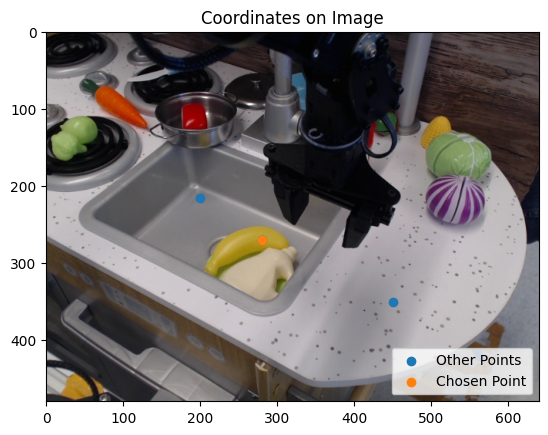

Output for task: pick up the can and put it next to the tomato.
with coordinates : [(130, 250), (500, 300), (300, 350)]:
 (500, 300)


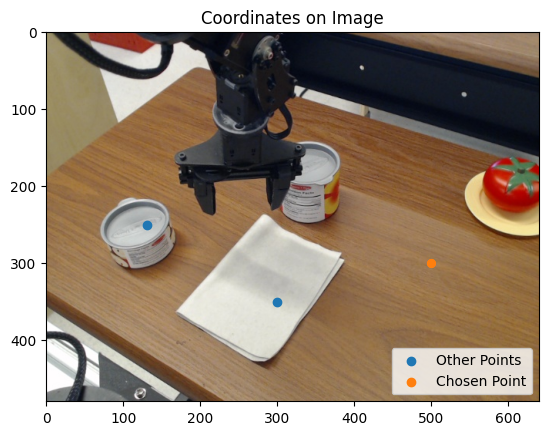

In [30]:
#task8 - can - (130,250) (380, 200) / (500, 300) (300, 350)
#task2 - vegetable (280, 270) (110, 90) (550, 200) / (205, 100) (450, 350) (200, 215)

tasks, images, groundtruths, objects_list = extract_all("../data/uncertain_experiments")
for i in range(len(tasks)):
    task = tasks[i]
    image_path = images[i]
    if("task2" in image_path):
        coordinates = [(280, 270), (450, 350), (200, 215)]
        output = do_vqa(coordinates, task, image_path, 0.2)
        print(f"Output for task: {task}")
        print(f"with coordinates : {coordinates}:")
        print(output)
        output = output.strip()  # Remove extra whitespace
        output = output.strip("()")  # Remove surrounding parentheses
        x, y = map(int, output.split(","))  # Convert to integers
        output = (x, y) 
        with Image.open(image_path) as image:
            visualize_points_on_image(image, ["Other Points", "Chosen Point"], [coordinates, [output]])
    if ("task8" in image_path):
        coordinates = [(130, 250), (500, 300), (300, 350)]
        output = do_vqa(coordinates, task, image_path, 0.2)
        print(f"Output for task: {task}")
        print(f"with coordinates : {coordinates}:")
        print(output)
        output = output.strip()  # Remove extra whitespace
        output = output.strip("()")  # Remove surrounding parentheses
        x, y = map(int, output.split(","))  # Convert to integers
        output = (x, y) 
        with Image.open(image_path) as image:
            visualize_points_on_image(image, ["Other Points", "Chosen Point"], [coordinates, [output]])
    else:
        continue
    

In [39]:
import string
import torch

def create_vqa_prompt(coordinates, task, width, height):
    choices = list(string.ascii_lowercase)
    prompt_coordinates = ""
    for i in range(len(coordinates)):
        prompt_coordinates += f"{choices[i]}: {coordinates[i]}, "

    
    prompt_start = "You are an expert in selecting the best answer in a multiple choice question style for succeeding in the specific task: "
    prompt_middle = f". There are {len(coordinates)} different answers containing coordinates from which you have to choose the most relevant one to succeed in the task. The width of the image is {width} pixels and the height of the image is {height} pixels. The multiple choice answers from which you have to choose are the following: "
    
    prompt_end = " Your output format should be only the letter of the answer that is the most likely. Do not use whitespace before or after the letter. Do not output anything else!"
    return prompt_start + task + prompt_middle + prompt_coordinates + prompt_end

def get_top_probability_distribution(output_char, output_tokens, tokenizer, top_k=10):
    softmax_fn = torch.nn.Softmax(dim=-1)

    logits = output.logits
    generated_logits = torch.cat(logits, dim=0)
    generated_tokens = output.sequences[0, inputs['input_ids'].size(1):]
    
    answer_token = generated_tokens[0]
    answer_logits = generated_logits[0]
    
    probs = softmax_fn(answer_logits.squeeze(0))
    
    token_prob = probs[answer_token].item()
    
    top_probs, top_indices = torch.topk(probs, top_k)
    top_tokens = [(tokenizer.decode([idx]), top_probs[i].item()) for i, idx in enumerate(top_indices)]

    return token_prob, top_tokens

def do_vqa(coordinates, task, image_path, temperature):
    with Image.open(image_path) as image:
        width = image.width
        height = image.height
        prompt = create_vqa_prompt(coordinates, task, width, height)
        print(f"Prompt: {prompt}")
        output_text, output, inputs = do_inference(image, prompt, model, processor, temperature)
    return output_text, output, inputs

In [40]:
#task8 - can - (130,250) (380, 200) / (500, 300) (300, 350)
#task2 - vegetable (280, 270) (110, 90) (550, 200) / (205, 100) (450, 350) (200, 215)

tasks, images, groundtruths, objects_list = extract_all("../data/uncertain_experiments")
for i in range(len(tasks)):
    task = tasks[i]
    image_path = images[i]
    if("task2" in image_path):
        coordinates = [(280, 270), (450, 350), (200, 215)]
        output_text, output, inputs = do_vqa(coordinates, task, image_path, 0.2)
        
        token_prob, top_tokens= get_top_probability_distribution(output_text, output, processor.tokenizer)
        print(f"Token_prob: {token_prob}")
        for token, prob in top_tokens:
            print(f"{token}: {prob:.4f}")
        print(f" Output: {output_text}")
    else:
        continue
    

Prompt: You are an expert in selecting the best answer in a multiple choice question style for succeeding in the specific task: pick up vegetable and put it on the table.. There are 3 different answers containing coordinates from which you have to choose the most relevant one to succeed in the task. The width of the image is 640 pixels and the height of the image is 480 pixels. The multiple choice answers from which you have to choose are the following: a: (280, 270), b: (450, 350), c: (200, 215),  Your output format should be only the letter of the answer that is the most likely. Do not use whitespace before or after the letter. Do not output anything else!
Token_prob: 0.4975808560848236
 c: 0.4976
 a: 0.2919
 b: 0.1709
 d: 0.0222
 A: 0.0045
 C: 0.0032
 B: 0.0027
 D: 0.0014
 letter: 0.0007
 f: 0.0005
 Output:  c


ValueError: invalid literal for int() with base 10: ' c'